<a href="https://colab.research.google.com/github/dansecret/Deep_Learning/blob/main/LabDL_04_Transfer_Learning_Praktikan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab DL 04: Transfer Learning Model CNN
Nama : Hamdandih

NIM  : 2000018350

# **1. Pendahuluan**

Di praktikum 4, praktikan akan mengimplementasikan model CNN yang sudah dilatih menggunakan ImageNet untuk diterapkan pada kasus klasifikasi citra dengan dataset baru. Cara ini disebut juga dengan transfer learning. 

Common approach is to leverage small image datasets for a pre-trained network. The spatial feature hierarchy will act as generic model of our visual world. This will prove very useful and can be repurposed easily. Such as one might use ImageNet then repurpose it for IKEA Furniture Detection. It makes things easier and robust for small dataset problem.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet has animal classes. But let us use this in our cat vs dog classification problem.

Ada 3 model CNN yang akan digunakan yaitu:
1. VGG16
2. ResNet50
3. MobileNetV2

## Preview Arsitektur Model
## VGG16
![VGG16](https://iq.opengenus.org/content/images/2019/01/vgg_layers.png)
## ResNet50
![ResNet50](https://www.researchgate.net/publication/349646156/figure/fig4/AS:995806349897731@1614430143429/The-architecture-of-ResNet-50-vd-a-Stem-block-b-Stage1-Block1-c-Stage1-Block2.png)
## MobileNetV2
![MobileNetV2](https://miro.medium.com/max/1016/1*5iA55983nBMlQn9f6ICxKg.png)

# **2. Mounting Google Drive**

In [12]:
from google.colab import drive

# mounting dataset dari gdrive
drive.mount('/content/gdrive', force_remount=True)

# lokasi dataset - ubah sesuai dengan lokasi anda mengupload folder datanya
# folder ini juga digunakan untuk menyimpan model yang sudah dilatih
root_path = 'gdrive/My Drive/DeepLearning/Deep Learning Labs/LabDL04 Data/'

# opsional - tampilkan info lokasi dataset
print("Path root:", root_path)

Mounted at /content/gdrive
Path root: gdrive/My Drive/DeepLearning/Deep Learning Labs/LabDL04 Data/


# **3. Download Dataset**
Download dataset dan simpan di gdrive yang sudah disediakan.
Kita menggunakan Flower Dataset yang terdiri 5 kelas yaitu daisy, dandelion, roses, sunflowers, dan tulips.

In [13]:
import os
import shutil
from six.moves import urllib
from os.path import join, exists

# lokasi gdrive untuk menyimpan dataset
FLOWERS_TGZ = join(root_path, 'flower_photos.tgz')
FLOWERS_DIR = join(root_path, 'flower_photos/')

# fungsi untuk mendownload dataset dan simpan di gdrive yang sudah disediakan
def download_images():
    if not exists(FLOWERS_DIR):
        DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        print('Mendownload dataset dari alamat %s...' % DOWNLOAD_URL)
        urllib.request.urlretrieve(DOWNLOAD_URL, FLOWERS_TGZ)
        shutil.unpack_archive(FLOWERS_TGZ, root_path)
        print('Flower dataset berhasil disimpan')
    else:
        print('Flower dataset sudah ada di gdrive anda')

# download dataset
download_images()

Flower dataset sudah ada di gdrive anda


# **4. Baca dan Split Dataset**
Baca dataset flower kemudian split dataset menjadi data latih, data validasi dan data uji. 

In [14]:
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018

# fungsi untuk split dataset menjadi data latih dan data uji
# resize juga citra dalam dataset tersebut menjadi ukuran (224,224,3)
def make_train_test_set(input_size=(224, 224, 3)):
    train_data, train_label, test_data, test_label = [], [], [], []
    shuffler = random.Random(RANDOM_SEED)

    # ambil folder yang ada didalam dataset
    (path_dirs, list_dirs, _) = next(os.walk(FLOWERS_DIR))
    list_dirs.sort()

    # folder -> nama kelas
    for i in range(len(list_dirs)):
        file_dir = join(path_dirs, list_dirs[i])
        (_, _, filenames) = next(os.walk(file_dir))

        # acak data citranya
        filenames.sort()
        shuffler.shuffle(filenames)

        # tentukan rasio data latih dan data uji
        num_train = int(len(filenames) * TRAIN_FRACTION)

        # bagi dataset menjadi data latih dan data uji
        for j in range(len(filenames)):
            file_name = join(file_dir, filenames[j])

            # baca citra
            bgr_img = cv2.imread(file_name)
            rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

            # resize ukuran citra agar seragam
            res_img = cv2.resize(rgb_img, (input_size[0], input_size[1]))
            
            # bagi kedalam data latih atau data uji secara acak
            if j < num_train:
                train_data.append(res_img)
                train_label.append(i)
            else:
                test_data.append(res_img)
                test_label.append(i)

    # konversi ke numpy array
    train_data = np.array(train_data)
    train_label = np.array(train_label)
    test_data = np.array(test_data)
    test_label = np.array(test_label)

    return train_data, test_data, train_label, test_label, list_dirs

# split dataset menjadi data latih dan data uji
X_data, X_test, y_data, y_test, class_name = make_train_test_set()

# bagi data latih untuk mendapatkan data validasi dengan rasio 70% - 30%
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, 
                                                  test_size=0.3, 
                                                  random_state=42)
# tampilkan informasi dataset
num_class = len(class_name)
print('Jumlah kelas:', num_class)
print('Label kelas:', class_name)
print('Dimensi data latih:', X_train.shape)
print('Dimensi data validasi:', X_val.shape)
print('Dimensi data uji:', X_test.shape)

Jumlah kelas: 5
Label kelas: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Dimensi data latih: (2053, 224, 224, 3)
Dimensi data validasi: (881, 224, 224, 3)
Dimensi data uji: (736, 224, 224, 3)


## Tampilkan Sampel Dataset

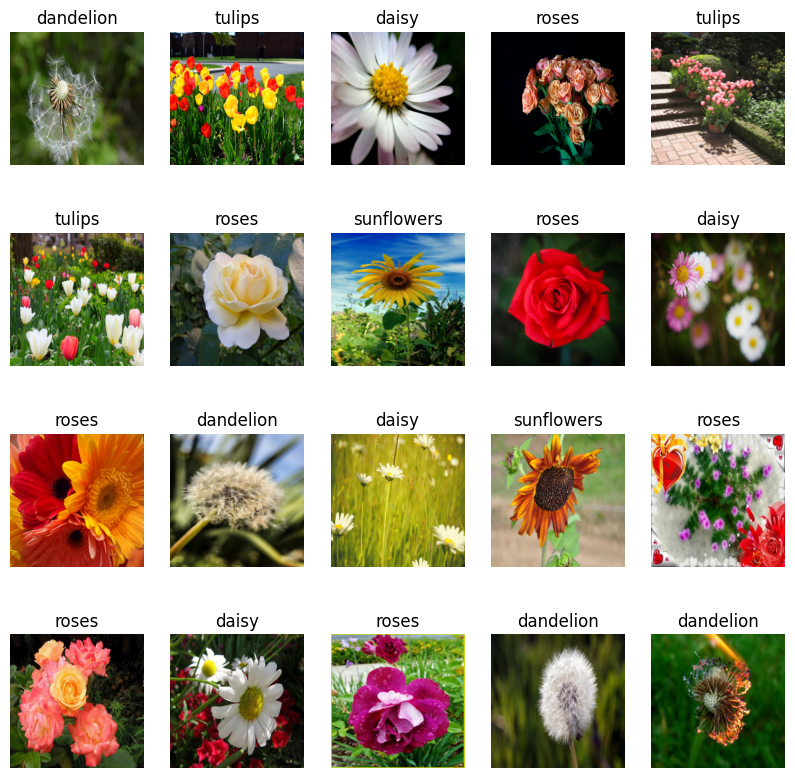

In [ ]:
import matplotlib.pyplot as plt

# tampilkan misalnya 20 citra pada dataset 
nimages = 20
ncols_plot = 5
nrows_plot = nimages//ncols_plot

plot_frame = plt.figure(figsize=(10,10))
for i in range(nimages):
    ax = plot_frame.add_subplot(nrows_plot, ncols_plot, i+1)
    ax.axis('off')
    ax.set_title(class_name[y_train[i]])
    plt.imshow(np.uint8(X_train[i]))

# **5. Membuat Augmentasi Data**
Perbaiki kode berikut agar pada data latih dilakukan augmentasi data sebagai berikut:
1. Lakukan scaling pada nilai pixel input citra sehingga menjadi rentang 0-1
2. Lakukan rotasi secara random dalam rentang 20 derajat
3. Lakukan horizontal flipping


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# input citra
input_size = (224, 224, 3)

# ukuran batch
batch_size = 32

# inisialisasi generator data latih dengan augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1./255,         # lakukan rescale agar piksel input citra berada pada rentang 0-1
    rotation_range=20,      # lakukan rotasi rentang 20 derajat
    horizontal_flip=True    # flipping horizontal
)
# inisialisasi generator data validasi
val_datagen = ImageDataGenerator(rescale=1./255)  
# inisialisasi generator data uji
test_datagen = ImageDataGenerator(rescale=1./255) 

# buat generator data latih
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, 
                                     shuffle=True)     
# buat generator data validasi                                
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size, 
                                 shuffle=True)
# buat generator data uji
test_generator = test_datagen.flow(X_test, y_test, batch_size=1, shuffle=True)

# **6. Membangun Model CNN**
Ada 3 pre-trained model dari ImageNet yang akan digunakan di praktikum ini yaitu:
1. VGG16
2. ResNet50
3. MobileNetV2

## 6.1. Pemilihan Model

In [35]:
from enum import Enum 

# nama model yang akan digunakan
class MODEL(Enum):
    TF_VGG16 = 1
    TF_ResNet50 = 2
    TF_MobileNetV2 = 3

# pilih model yang akan digunakan sekarang
# ganti nama model disini untuk mencoba model yang lain
# opt_model = MODEL.TF_VGG16 
# opt_model = MODEL.TF_ResNet50
opt_model = MODEL.TF_MobileNetV2

# jumlah epoch pelatihan
epochs = 30

## 6.2. Fungsi Pre-Trained Model

In [36]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.callbacks import ModelCheckpoint

We passed three arguments:

* `weights`, specify which weight checkpoint initializes the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. 
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size.

In [37]:
# input layer
inputs = Input(shape=input_size)
 
# pilih base model 
if opt_model == MODEL.TF_VGG16: 
    # lokasi untuk menyimpan hasil pelatihan
    checkpoint_filepath = join(root_path, 'lab04_vgg16_model.h5') 

    # load base model VGG16 untuk ekstraksi fitur
    base_model = VGG16(include_top=False, 
                       weights='imagenet',  # pre-trained dari ImageNet 
                       input_shape=input_size)

elif opt_model == MODEL.TF_ResNet50: 
    # lokasi untuk menyimpan hasil pelatihan
    checkpoint_filepath = join(root_path, 'lab04_resnet50_model.h5') 

    # load base model ResNet50 untuk ekstraksi fitur
    base_model = ResNet50(include_top=False, 
                          weights='imagenet',  # pre-trained dari ImageNet 
                          input_shape=input_size)

elif opt_model == MODEL.TF_MobileNetV2: 
    # lokasi untuk menyimpan hasil pelatihan
    checkpoint_filepath = join(root_path, 'lab04_mobilenetv2_model.h5') 

    # load base model MobileNetV2 untuk ekstraksi fitur
    base_model = MobileNetV2(include_top=False, 
                             weights='imagenet', # pre-trained dari ImageNet 
                             input_shape=input_size)

base_model.summary() # menampilkan summary dari base model yang dipilih

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

### Freezing the base_model
Notice the `base_model.trainable = False` setting. It freezes the weights and biases of the pre-trained model so that you train your softmax layer only. This typically involves relatively few weights and can be done quickly and without necessitating a very large dataset. 

However if you do have lots of data, transfer learning can work even better with `base_model.trainable = True`. The pre-trained weights then provide excellent initial values and can still be adjusted by the training to better fit your problem.

In [38]:
# freeze the base layer
base_model.trainable = True

# tambahkan input ke base model
add_layer = base_model(inputs, training=False)

# flatten layer sebelum masuk ke FC layer
add_layer = Flatten()(add_layer)

In [39]:
# sesuaikan dengan jumlah kategori luarannya
# output layer: dense -> softmax 
output_layer = Dense(num_class, activation='softmax', name='main_model')(add_layer) 

# membangun model untuk klasifikasi
main_model = Model(inputs=inputs, outputs=output_layer, name='LabDL04')

# pilih optimizer dan compile modelnya
init_learning_rate = 1e-4 
opt_optimizer = Adam(learning_rate=init_learning_rate) 
main_model.compile(optimizer=opt_optimizer, 
                   loss='sparse_categorical_crossentropy', 
                   loss_weights=1.0, 
                   metrics=['accuracy']) 
main_model.summary() # menampilkan summary dari model yang dibuat

# simpan model yang mendapatkan akurasi validasi tertinggi
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    save_weights_only=False, 
    monitor='val_loss', 
    verbose=1, 
    mode='auto', 
    save_best_only=True) 

Model: "LabDL04"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 62720)             0         
                                                                 
 main_model (Dense)          (None, 5)                 313605    
                                                                 
Total params: 2,571,589
Trainable params: 2,537,477
Non-trainable params: 34,112
_________________________________________________________________


# **7. Pelatihan Model CNN**

In [40]:
# mulai pelatihan dengan n epochs
history = main_model.fit(train_generator, 
                         batch_size=batch_size, 
                         validation_data=val_generator,
                         epochs=epochs, 
                         callbacks=[model_checkpoint_callback],
                         verbose=1)

Epoch 1/30
65/65 [==============================] - ETA: 0s - loss: 0.8784 - accuracy: 0.6556
Epoch 1: val_loss improved from inf to 0.44923, saving model to gdrive/My Drive/DeepLearning/Deep Learning Labs/LabDL04 Data/lab04_mobilenetv2_model.h5
65/65 [==============================] - 62s 439ms/step - loss: 0.8784 - accuracy: 0.6556 - val_loss: 0.4492 - val_accuracy: 0.8411
Epoch 2/30
65/65 [==============================] - ETA: 0s - loss: 0.4396 - accuracy: 0.8393
Epoch 2: val_loss did not improve from 0.44923
65/65 [==============================] - 26s 394ms/step - loss: 0.4396 - accuracy: 0.8393 - val_loss: 0.5019 - val_accuracy: 0.8161
Epoch 3/30
65/65 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.9001
Epoch 3: val_loss improved from 0.44923 to 0.32309, saving model to gdrive/My Drive/DeepLearning/Deep Learning Labs/LabDL04 Data/lab04_mobilenetv2_model.h5
65/65 [==============================] - 28s 423ms/step - loss: 0.2816 - accuracy: 0.9001 - val_los

## Menampilkan statistik pelatihan

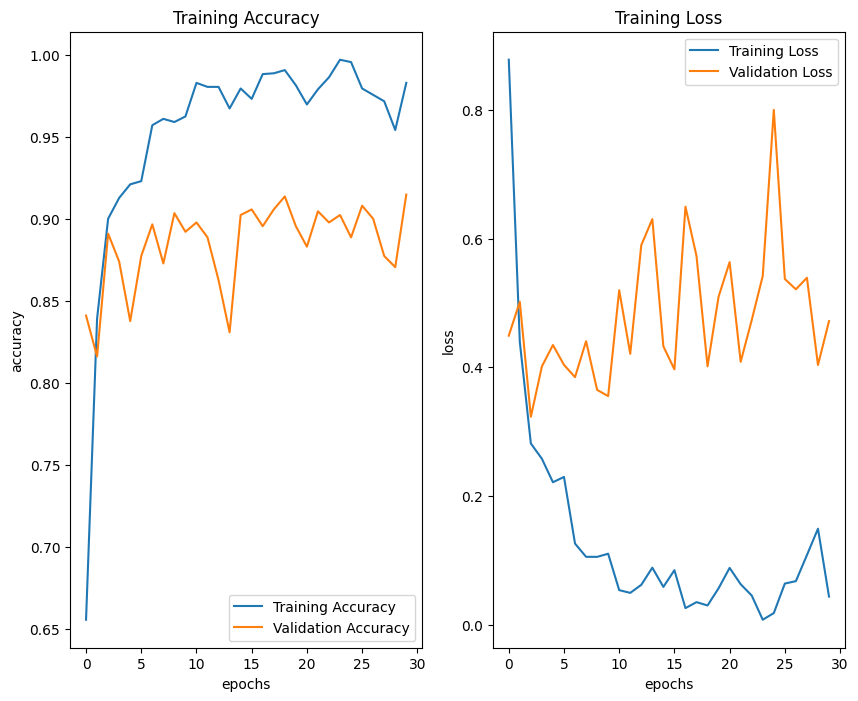

In [41]:
# ambil statistik pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

# plot hasil akurasi pelatihan
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy') 
plt.xlabel('epochs')
plt.title('Training Accuracy')

# plot hasil loss pelatihan
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('loss') 
plt.xlabel('epochs')
plt.title('Training Loss')
plt.show()

Untuk transfer learning pada model VGG16 dan MobileNetV2 pelatihan dengan 20 epochs sudah cukup untuk mendapatkan akurasi yang tinggi tetapi sering terjadi overfitting akan tetapi untuk model ResNet50 akan perlu epochs yang lebih banyak.

# **8. Evaluasi Model**

In [42]:
from tensorflow.keras.models import load_model

# load hasil pelatihan untuk di uji
trained_model = load_model(checkpoint_filepath)

# pengujian dengan data uji
trained_model.evaluate(test_generator, verbose=1) 

736/736 [==============================] - 7s 8ms/step - loss: 0.2969 - accuracy: 0.8995


[0.29687947034835815, 0.8994565010070801]

## 8.1. Tampilkan Hasil Pengujian

  0%|          | 0/736 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


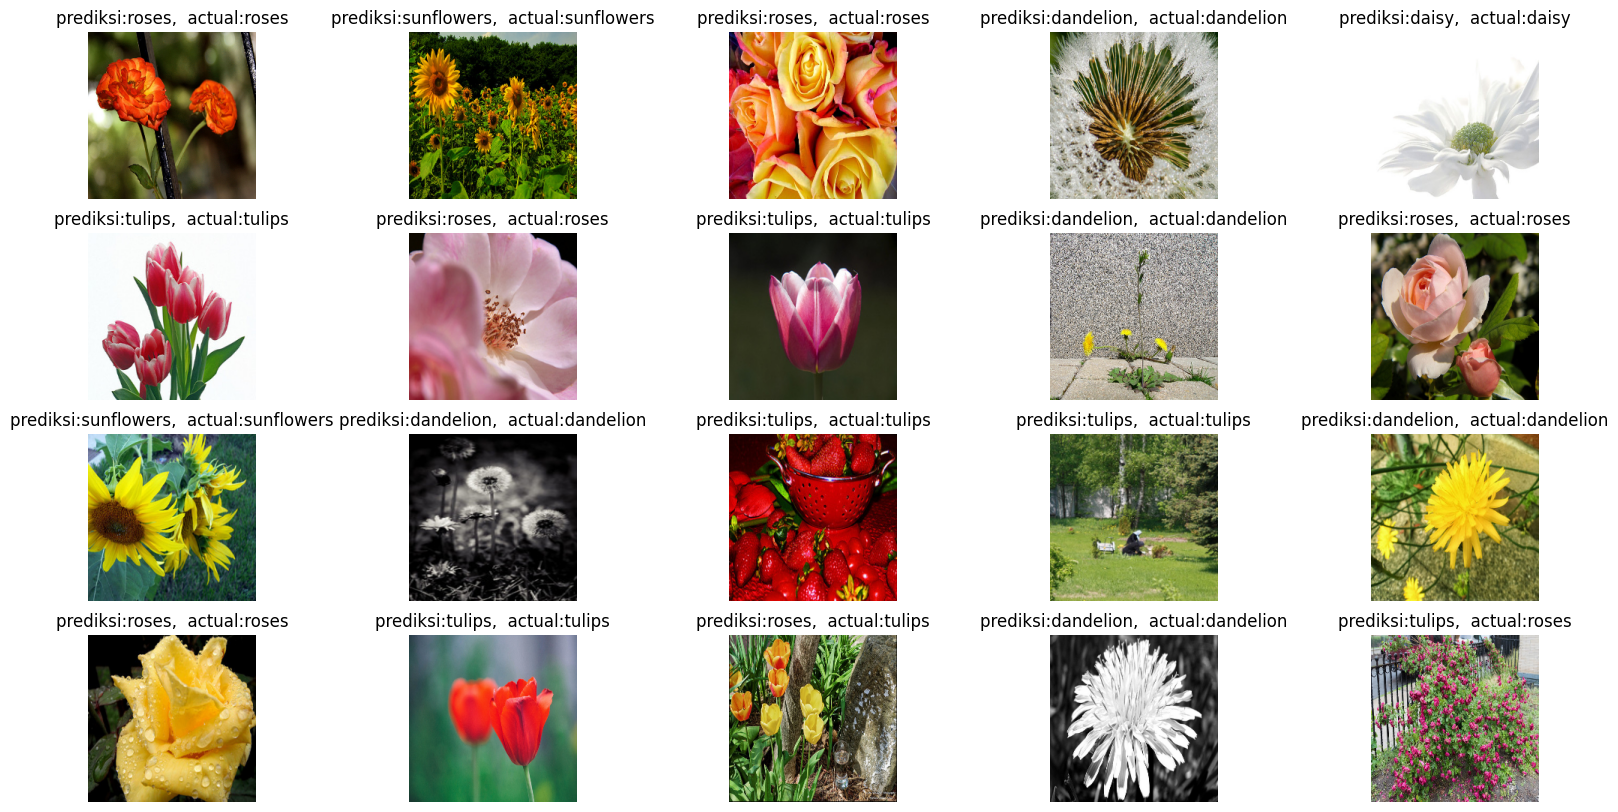

In [43]:
from tqdm.notebook import tqdm_notebook

# tampilkan misalnya 20 citra pada dataset 
nimages = 20
ncols_plot = 5
nrows_plot = nimages//ncols_plot

y_predict = []
y_actual = []
count_imgs = 0
plot_frame = plt.figure(figsize=(20,10))

# one-by-one prediction
for i in tqdm_notebook(range(len(test_generator))):
    imgs, labels = next(test_generator)
    labels = np.array(labels, dtype=np.uint8)
    for j in range(len(imgs)):
        X_batch = np.expand_dims(imgs[j], axis=0)
        prediction_scores = trained_model.predict(X_batch)
        score = np.argmax(prediction_scores)
        y_predict.append(score)
        y_actual.append(labels[j])

        # tampilkan 20 hasil pengujian
        if (count_imgs < nimages):
            ax = plot_frame.add_subplot(nrows_plot, ncols_plot, count_imgs+1)
            ax.axis('off')
            ax.set_title("prediksi:" + class_name[score] + \
                        ",  actual:" + class_name[labels[j]])
            plt.imshow(np.uint8(imgs[j]*255))
        count_imgs += 1

y_predict = np.array(y_predict)
y_actual = np.array(y_actual)

## 8.2. Membuat Confusion Matrix

Laporan Klasifikasi Data Uji:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       127
           1       0.96      0.96      0.96       180
           2       0.78      0.94      0.85       129
           3       0.98      0.89      0.93       140
           4       0.91      0.79      0.85       160

    accuracy                           0.90       736
   macro avg       0.90      0.90      0.90       736
weighted avg       0.91      0.90      0.90       736

Confusion Matrix:
[[118   5   2   0   2]
 [  4 172   1   2   1]
 [  1   1 121   1   5]
 [  6   0   5 125   4]
 [  5   2  27   0 126]]


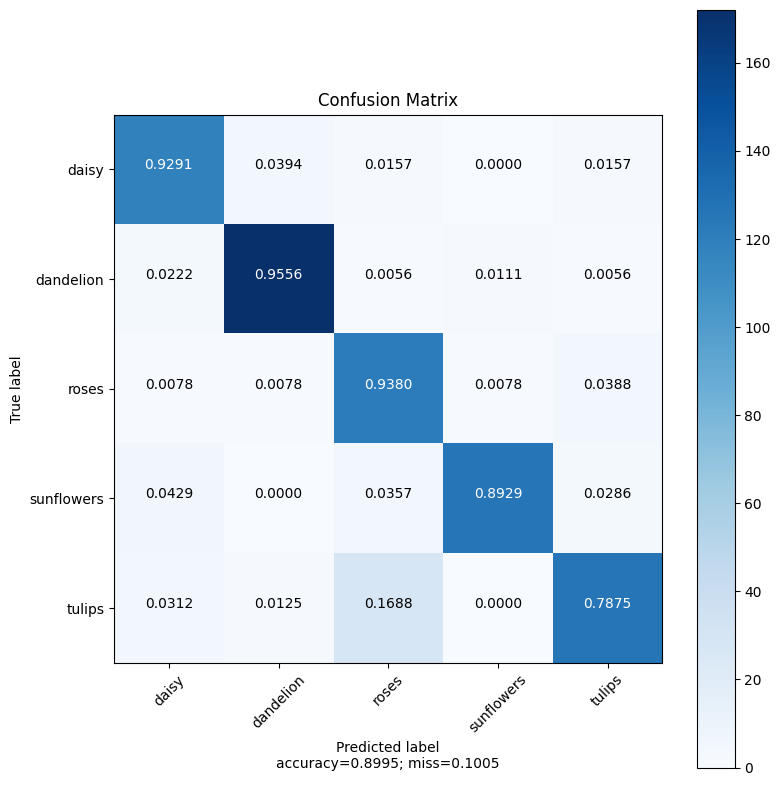

In [44]:
import itertools
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# cetak laporan hasil klasifikasi data uji
print('Laporan Klasifikasi Data Uji:')
print(classification_report(y_actual, y_predict))

# hitung confusion matrixnya
conf_mat_result = confusion_matrix(y_actual, y_predict)

# cetak confusion matrix
print('Confusion Matrix:')
print(conf_mat_result)

accuracy = np.trace(conf_mat_result) / np.sum(conf_mat_result).astype('float') 
misclass = 1 - accuracy

# masukkan nama kelas di dataset
target_names = class_name
plt.figure(figsize=(8, 8)) 
cmap = plt.get_cmap('Blues') 
  
plt.imshow(conf_mat_result, interpolation='nearest', cmap=cmap) 
plt.title('Confusion Matrix') 
plt.colorbar() 

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45) 
plt.yticks(tick_marks, target_names)

cm = conf_mat_result.astype('float') / conf_mat_result.sum(axis=1)[:, np.newaxis] 
thresh = cm.max() / 1.5 
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, "{:0.4f}".format(cm[i, j]),
        horizontalalignment='center',
        color='white' if cm[i, j] > thresh else 'black') 

plt.tight_layout()
plt.ylabel('True label') 
plt.xlabel('Predicted label\naccuracy={:0.4f}; miss={:0.4f}'.format(accuracy, misclass)) 
plt.show() 

# **9. Post Test**
1.	Ubah kembali pilihan model di langkah nomor 14 pada instruksi praktikum menjadi model VGG16 atau MobileNetV2 (pilih salah satu) sebagai berikut:
`opt_model = MODEL.TF_VGG16` **atau**
`opt_model = MODEL.TF_MobileNetV2` 
2.	Set inisial bobot dari pre-trained ImageNet yang semula di freeze menjadi dapat dilatih dengan cara mengubah kodenya sebagai berikut.
`base_model.trainable = True`
3.	Jalankan semua tahap sampai ke evaluasi (seperti langkah nomor 14 - 18 di instruksi praktikum).
4.	Amati hasil pelatihannya. 
5.	Apakah ada peningkatan akurasi dibandingkan dengan saat bobot di base model VGG16 atau di MobileNetV2 yang anda pilih di freeze? Jika iya jelaskan mengapa bisa demikian? 
6.	Apabila terjadi overfitting maka modifikasi layer setelah Flatten() layer dan sebelum Output layer dengan cara menambahkan fully connected layer lagi diikuti dengan dropout, dsb seperti yang anda pelajari di praktikum sebelumnya. 
7. Tambah jumlah epochs agar pelatihan dan pengujiannya maksimal.
